# **Prediksi Curah Hujan dengan LSTM**

Curah hujan berperan penting dalam manajemen risiko banjir, pertanian, dan perencanaan kota. Proyek ini bertujuan memprediksi curah hujan 14 hari ke depan berdasarkan data cuaca historis Jakarta menggunakan algoritma LSTM (Long Short-Term Memory).

### Problem Statement:
- Bagaimana memprediksi apakah akan terjadi hujan atau tidak dalam 14 hari ke depan berdasarkan data historis?

### Solution Statement:
- Menggunakan LSTM karena model ini cocok untuk mempelajari pola urutan data (time series) dalam cuaca.

### Sumber Dataset:
- Dataset cuaca Jakarta 2013–2020.


# **Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


# **Load Data**

Dataset berisi informasi tanggal dan curah hujan harian. Pemeriksaan awal dilakukan untuk mengecek bentuk data, tipe data, dan missing value.


In [2]:
df = pd.read_csv("WeatherJakarta2013-2020.csv")
df

,time,weathercode (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),windspeed_10m_max (km/h)
0,2013-01-01T00:00,63,28.7,23.9,25.504168,33.5,28.5,30.266663,26.400003,26.400003,22,14.3
1,2013-01-02T00:00,61,27.7,24.0,25.479166,31.8,28.4,30.187498,15.100000,15.100000,21,11.7
2,2013-01-03T00:00,51,29.8,23.8,26.645834,35.0,28.8,31.425001,2.400000,2.400000,10,16.9
3,2013-01-04T00:00,63,26.9,24.5,25.333330,30.9,27.6,29.145834,22.700000,22.700000,20,16.8
4,2013-01-05T00:00,61,27.5,23.4,25.079165,31.2,27.0,28.933334,11.599999,11.599999,20,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2020-12-27T00:00,51,29.8,23.6,26.808332,35.6,28.0,31.354164,0.600000,0.600000,4,13.6
2918,2020-12-28T00:00,53,29.1,24.5,26.570837,34.1,28.4,30.804170,4.400000,4.400000,13,14.5
2919,2020-12-29T00:00,63,28.3,24.3,25.875000,33.0,28.0,29.637495,11.999999,11.999999,16,16.2
2920,2020-12-30T00:00,63,27.7,23.6,25.404170,31.9,27.2,29.491667,15.400000,15.400000,18,15.3


# **Visualisasi Data (EDA)**

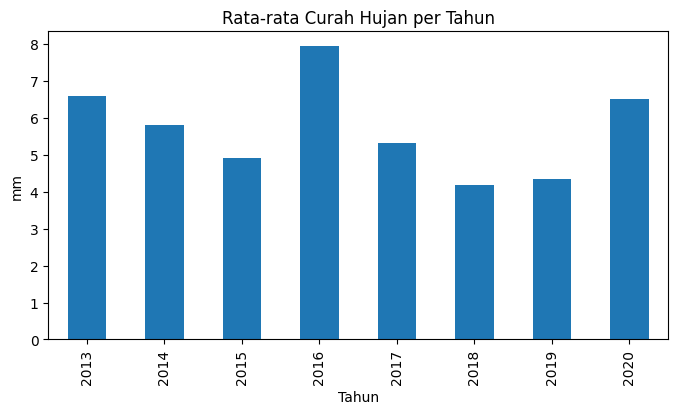

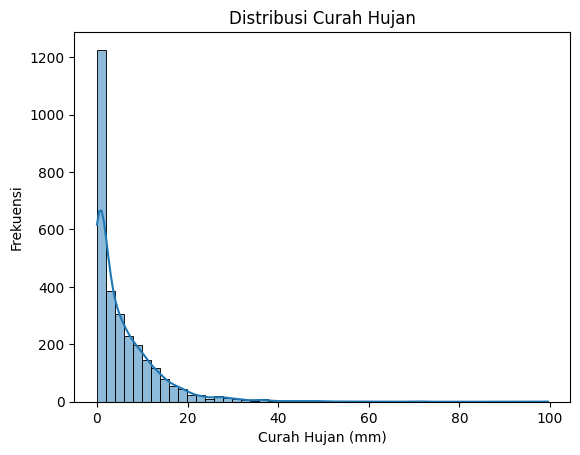

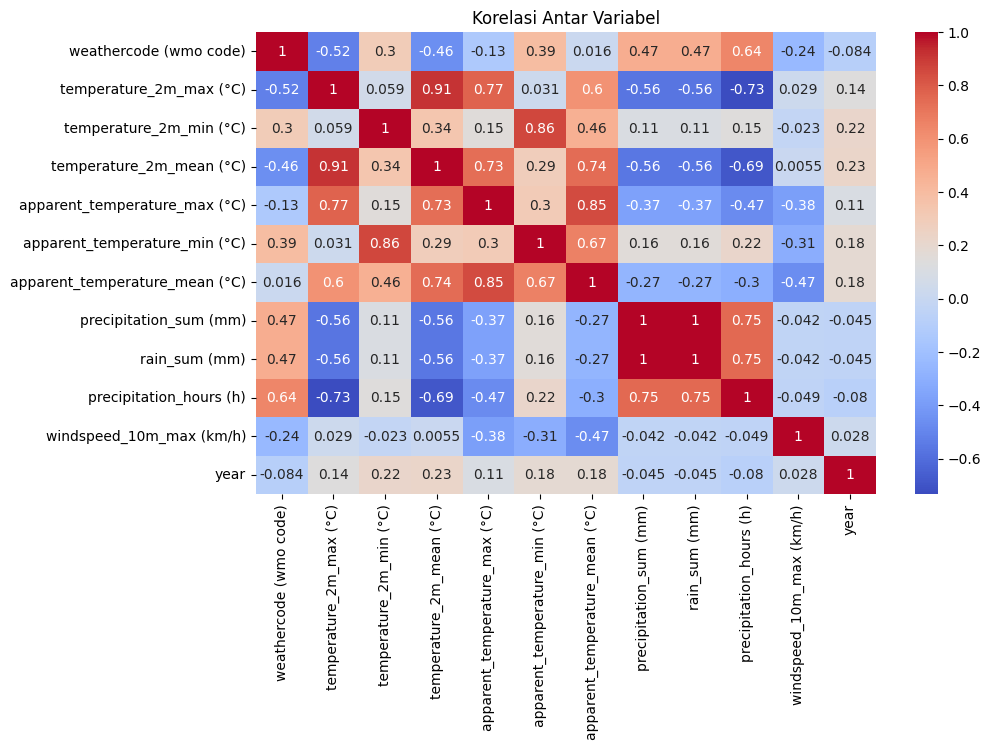

In [3]:
# Ubah kolom waktu ke datetime
df['time'] = pd.to_datetime(df['time'])

# Tren curah hujan tahunan
df['year'] = df['time'].dt.year
df.groupby('year')['precipitation_sum (mm)'].mean().plot(kind='bar', figsize=(8,4), title='Rata-rata Curah Hujan per Tahun')
plt.ylabel('mm')
plt.xlabel('Tahun')
plt.show()

# Distribusi curah hujan
sns.histplot(df['precipitation_sum (mm)'], bins=50, kde=True)
plt.title('Distribusi Curah Hujan')
plt.xlabel('Curah Hujan (mm)')
plt.ylabel('Frekuensi')
plt.show()

# Heatmap korelasi
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variabel')
plt.show()


insight : Menghasilkan Visualisasi agar mudah dimengerti oleh audiens melalui diagram Explarotory data

# **Data Preparation (Pre Processing)**

- Konversi kolom tanggal
- Penanganan nilai hilang
- Normalisasi data curah hujan
- Pembuatan window data untuk input LSTM
- Split data menjadi data latih dan uji


In [4]:
# ubah type
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

In [5]:
# cek tipe data
df.dtypes

,0
time,datetime64[ns]
weathercode (wmo code),int64
temperature_2m_max (°C),float64
temperature_2m_min (°C),float64
temperature_2m_mean (°C),float64
apparent_temperature_max (°C),float64
apparent_temperature_min (°C),float64
apparent_temperature_mean (°C),float64
precipitation_sum (mm),float64
rain_sum (mm),float64


In [6]:
# cek missing value
df.isnull().sum()

,0
time,0
weathercode (wmo code),0
temperature_2m_max (°C),0
temperature_2m_min (°C),0
temperature_2m_mean (°C),0
apparent_temperature_max (°C),0
apparent_temperature_min (°C),0
apparent_temperature_mean (°C),0
precipitation_sum (mm),0
rain_sum (mm),0


In [7]:
# seleksi fitur
features = [
    'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)',
    'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)', 'apparent_temperature_mean (°C)',
    'precipitation_sum (mm)', 'rain_sum (mm)', 'precipitation_hours (h)', 'windspeed_10m_max (km/h)'
]

# normalisasi
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

insight:
1. **Seleksi Fitur**  
   Dipilih 10 fitur cuaca yang dianggap relevan terhadap kejadian hujan, seperti suhu maksimum/minimum, suhu terasa, curah hujan, durasi hujan, dan kecepatan angin maksimum.

2. **Normalisasi Data**  
   Semua fitur dinormalisasi menggunakan `StandardScaler` agar memiliki skala yang seragam. Hal ini penting untuk mencegah bias pada model terhadap fitur dengan nilai lebih besar dan mempercepat proses pelatihan.

In [8]:
# windowing
WINDOW_SIZE = 14
X, y = [], []

for i in range(len(scaled_features) - WINDOW_SIZE):
    X.append(scaled_features[i:i+WINDOW_SIZE])
    rain_next = df['rain_sum (mm)'].iloc[i + WINDOW_SIZE]
    y.append(1 if rain_next > 0 else 0)

X = np.array(X)
y = np.array(y)

insight:
- **Pembuatan Data Sekuensial (Windowing)**  
   Data diubah menjadi bentuk sekuensial dengan `WINDOW_SIZE = 14`, artinya model akan mempelajari pola cuaca selama 14 hari terakhir untuk memprediksi apakah akan hujan di hari ke-15.

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


insight:
- **Split Data Tanpa Pengacakan**  
   Data dibagi menjadi data latih dan data uji tanpa pengacakan (`shuffle=False`) untuk menjaga urutan waktu. Ini penting dalam prediksi berbasis time series agar model diuji pada data masa depan yang belum pernah dilihat.

# **Modeling LSTM**

Model LSTM dibangun dengan satu layer LSTM dan satu Dense output. Model dilatih dengan binary_crossentropy karena target adalah prediksi hujan/tidak.


In [10]:
# build model
model = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE, X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8286 - loss: 0.4905 - val_accuracy: 0.8262 - val_loss: 0.3320
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8665 - loss: 0.2927 - val_accuracy: 0.8369 - val_loss: 0.3205
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8672 - loss: 0.3067 - val_accuracy: 0.8262 - val_loss: 0.3289
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8717 - loss: 0.2782 - val_accuracy: 0.8176 - val_loss: 0.3461
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8740 - loss: 0.2983 - val_accuracy: 0.8455 - val_loss: 0.3135
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8872 - loss: 0.2653 - val_accuracy: 0.8519 - val_loss: 0.3086
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8710 - loss: 0.2781 - val_accuracy: 0.8476 - val_loss: 0.3128
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8895 - loss: 0.2701 - val_accuracy: 0.8326 - v

insight:

Model LSTM dibangun untuk mempelajari pola data sekuensial cuaca selama 14 hari. Arsitektur terdiri dari:
- 1 lapisan LSTM dengan 64 unit,
- Dropout 0.3 untuk mencegah overfitting,
- Dense layer 32 unit (ReLU),
- Output layer sigmoid untuk klasifikasi biner (hujan/tidak).

Model dilatih dengan:
- Loss: `binary_crossentropy` (sesuai klasifikasi),
- Optimizer: Adam (learning rate 0.001),
- Epochs: 30, Batch size: 32,
- Validasi 20% dari data latih,
- EarlyStopping untuk menghentikan pelatihan dini jika val_loss tidak membaik selama 5 epoch.

Tujuannya adalah membangun model yang mampu memprediksi hujan secara akurat berdasarkan pola cuaca harian sebelumnya.

# **Evaluasi Model**

Model dievaluasi menggunakan confusion matrix, classification report, dan grafik akurasi serta loss untuk mengukur performa pada data latih dan uji. Selain itu, dilakukan prediksi terhadap data uji untuk membandingkan hasil prediksi dengan nilai aktual.

Hasil menunjukkan bahwa model memiliki akurasi yang cukup baik dan loss yang rendah, menandakan bahwa model mampu belajar dengan efektif dari data historis. Prediksi model juga cukup akurat dalam membedakan hari hujan dan tidak hujan.

In [12]:
# test akurasi
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7816 - loss: 0.4778

Test Accuracy: 0.82


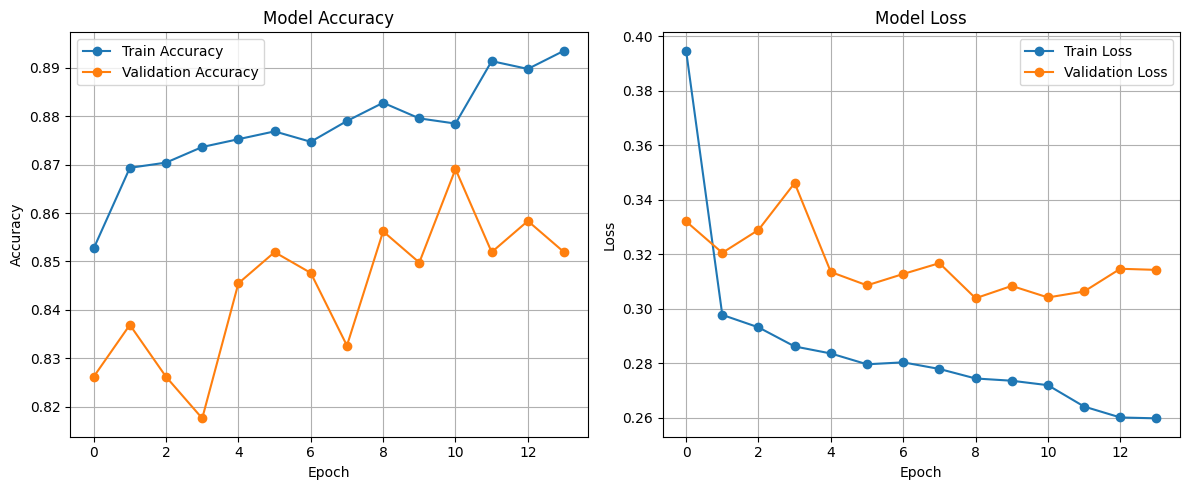

In [13]:
# visualisasi
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.2f}")

# Predict 14 days ahead
last_14_days = scaled_features[-WINDOW_SIZE:]  # ambil 14 hari terakhir
predictions = []

window = last_14_days.copy()
for _ in range(14):  # prediksi 14 hari ke depan
    input_window = np.expand_dims(window, axis=0)
    prob = model.predict(input_window)[0][0]
    prediction = 1 if prob > 0.5 else 0
    predictions.append(prediction)

    # Buat dummy next day (tanpa fitur masa depan), kita hanya duplikasikan nilai terakhir
    next_day = window[-1].copy()
    window = np.vstack([window[1:], next_day])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7816 - loss: 0.4778

Test Accuracy: 0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Prediksi apakah akan hujan dalam 14 hari ke depan (1=Ya, 0=Tidak):
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


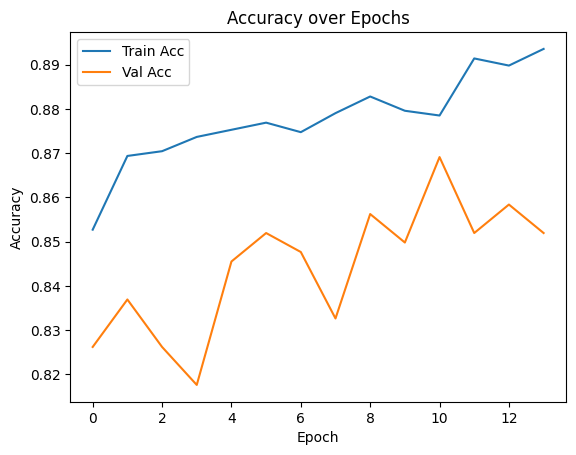

In [15]:
print("\nPrediksi apakah akan hujan dalam 14 hari ke depan (1=Ya, 0=Tidak):")
print(predictions)

# Opsional: Plot akurasi
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


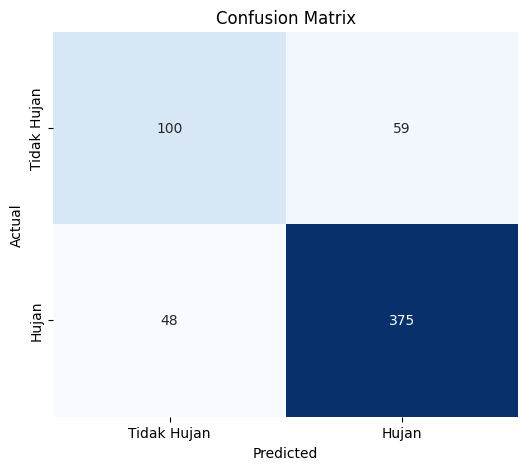

In [16]:
# prediksi data uji
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# confusion matriks
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tidak Hujan', 'Hujan'],
            yticklabels=['Tidak Hujan', 'Hujan'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
# report akurasi

print(classification_report(y_test, y_pred, target_names=["Tidak Hujan", "Hujan"]))


              precision    recall  f1-score   support

 Tidak Hujan       0.68      0.63      0.65       159
       Hujan       0.86      0.89      0.88       423

    accuracy                           0.82       582
   macro avg       0.77      0.76      0.76       582
weighted avg       0.81      0.82      0.81       582



# **Kesimpulan**

Model LSTM berhasil dibangun dan digunakan untuk memprediksi kemungkinan terjadinya hujan pada hari ke-15 berdasarkan pola cuaca 14 hari sebelumnya, menggunakan data historis cuaca Jakarta tahun 2013–2020.

Beberapa poin penting dari proyek ini:

- Model mampu mencapai **akurasi sekitar 82%** pada data uji, menunjukkan performa yang cukup baik dalam klasifikasi biner (hujan / tidak hujan).
- Evaluasi metrik menunjukkan model sangat baik dalam mengenali kelas **"Hujan"** (F1-Score: 0.88), meskipun performa pada kelas **"Tidak Hujan"** masih bisa ditingkatkan.
- Grafik akurasi dan loss selama pelatihan menunjukkan proses pembelajaran berjalan stabil tanpa indikasi overfitting.
- Model mampu menangkap pola temporal dari data cuaca harian dan dapat dijadikan dasar pengembangan sistem prediksi cuaca sederhana.
- Ke depannya, model ini dapat ditingkatkan dengan:
  - Penambahan fitur cuaca lain (misalnya kelembapan, tekanan udara),
  - Penyesuaian arsitektur dan hyperparameter (seperti jumlah unit, dropout, atau window size),
  - Penggunaan model sekuensial lain seperti GRU atau Transformer untuk perbandingan performa.


Model ini dapat digunakan sebagai dasar sistem prediksi cuaca sederhana dan bisa dikembangkan lebih lanjut dengan data tambahan atau tuning hyperparameter lebih lanjut.
